<a href="https://colab.research.google.com/github/hfwalvir/Dissertation/blob/main/Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.1 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/content/sample_data/invoices.csv')

df.head()

,first_name,last_name,email,product_id,qty,amount,invoice_date,address,city,stock_code,job
0,Carmen Nixon,Todd Anderson,marvinjackson@example.com,133,9,14.57,10/09/1982,283 Wendy Common,West Alexander,36239634,Logistics and distribution manager
1,Mrs. Heather Miller,Julia Moore,jeffrey84@example.net,155,5,65.48,03/10/2012,13567 Patricia Circles Apt. 751,Andreamouth,2820163,Osteopath
2,Crystal May,Philip Moody,ugoodman@example.com,151,9,24.66,23/03/1976,6389 Debbie Island Suite 470,Coxbury,27006726,Economist
3,Bobby Weber,Mark Scott,ssanchez@example.com,143,4,21.34,17/08/1986,6362 Ashley Plaza Apt. 994,Ninaland,83036521,Sports administrator
4,Kristen Welch,David David,cynthia66@example.net,168,2,83.90,11/06/1996,463 Steven Cliffs Suite 757,Isaiahview,80142652,Chief Marketing Officer


# **FINDING OPTIMIZED PAYMENT TERMS**

In [17]:
# Preprocess the data
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d/%m/%Y')
df['days_since_invoice'] = (pd.Timestamp.now() - df['invoice_date']).dt.days

# Create a binary target variable (e.g., paid within 30 days)
df['paid_on_time'] = (df['days_since_invoice'] <= 30).astype(int)

# Select features for the model
features = ['qty', 'amount', 'days_since_invoice', 'stock_code']
X = df[features]
y = df['paid_on_time']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simulate federated learning by splitting data into "clients"
num_clients = 3
client_data = np.array_split(X_train_scaled, num_clients)
client_labels = np.array_split(y_train, num_clients)

# Federated Learning
def federated_learning(client_data, client_labels, num_rounds=5):
    global_model = RandomForestClassifier(n_estimators=100, random_state=42)

    for round in range(num_rounds):
        print(f"Round {round + 1}")
        client_predictions = []

        for i in range(len(client_data)):
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(client_data[i], client_labels[i])
            client_predictions.append(model.predict_proba(np.concatenate(client_data)))

        # Aggregate predictions (simple averaging)
        aggregated_predictions = np.mean(client_predictions, axis=0)

        # Update global model
        global_model.fit(np.concatenate(client_data), np.argmax(aggregated_predictions, axis=1))

    return global_model

# Train the federated model
federated_model = federated_learning(client_data, client_labels)

# Evaluate the model
y_pred = federated_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")

# Function to suggest optimal payment terms
def suggested_payment_terms(model, invoice_data, scaler):
    # Prepare features
    features = pd.DataFrame({
        'qty': [invoice_data['qty']],
        'amount': [invoice_data['amount']],
        'days_since_invoice': [0],  # New invoice
        'stock_code': [invoice_data['stock_code']]
    })

    # Scale features
    features_scaled = scaler.transform(features)

    # Try different payment terms
    best_terms = 30
    best_prob = 0
    for terms in range(15, 61, 5):  # Try terms from 15 to 60 days
        features_scaled[0, 2] = terms  # Update days_since_invoice
        proba = model.predict_proba(features_scaled)[0]
        if len(proba) == 1:
            prob = proba[0]  # If only one class, assume it's the probability of on-time payment
        else:
            prob = proba[1]  # Probability of on-time payment (assuming binary classification)
        if prob > best_prob:
            best_prob = prob
            best_terms = terms

    return best_terms, best_prob

# Example usage
new_invoice = {
    'qty': 5,
    'amount': 100.0,
    'stock_code': 12345
}
optimal_terms, payment_prob = suggested_payment_terms(federated_model, new_invoice, scaler)
print(f"Suggested payment terms: {optimal_terms} days")
print(f"Probability of on-time payment: {payment_prob:.2f}")


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Round 1
Round 2
Round 3
Round 4
Round 5
Model accuracy: 1.0000
Suggested payment terms: 15 days
Probability of on-time payment: 1.00


# **PREDICTION OF REQUISITE INVENTORY LEVELS**

In [18]:
data = pd.read_csv('/content/sample_data/invoices.csv')


In [19]:
import pandas as pd
import numpy as np
# Set a random seed for reproducibility
np.random.seed(42)

# Generate random financial data
n_samples = len(data)
data['cash'] = np.random.uniform(10000, 1000000, n_samples)
data['accounts_receivable'] = np.random.uniform(5000, 500000, n_samples)
data['inventory'] = np.random.uniform(20000, 2000000, n_samples)
data['fixed_assets'] = np.random.uniform(50000, 5000000, n_samples)
data['accounts_payable'] = np.random.uniform(5000, 500000, n_samples)
data['short_term_debt'] = np.random.uniform(10000, 1000000, n_samples)
data['long_term_debt'] = np.random.uniform(50000, 5000000, n_samples)
data['revenue'] = np.random.uniform(100000, 10000000, n_samples)
data['cogs'] = np.random.uniform(50000, 5000000, n_samples)
data['annual_revenue_growth_rate'] = np.random.uniform(0, 40, n_samples)
data['market_expansion'] = np.random.choice([True, False], n_samples)
data['investment_in_innovation'] = np.random.uniform(0, 20, n_samples)
data['capital_expenditure'] = np.random.uniform(5, 25, n_samples)
data['employee_growth_rate'] = np.random.uniform(0, 30, n_samples)
data['profit_margins'] = np.random.uniform(0, 15, n_samples)
data['external_funding'] = np.random.choice([True, False], n_samples)
data['cash_conversion_cycle'] = np.random.randint(30, 90, n_samples)


In [20]:
def calculate_min_inventory_threshold(revenue, cogs, revenue_growth_rate, market_expansion, investment_in_innovation, capital_expenditure, employee_growth_rate, profit_margins, external_funding, cash_conversion_cycle):
    # Factors for market expansion, innovation, capital expenditure, and employee growth
    market_expansion_factor = 1.2 if market_expansion else 1.0
    investment_in_innovation_factor = 1.1 if investment_in_innovation > 10 else 1.0
    capital_expenditure_factor = 1.1 if capital_expenditure > 10 else 1.0
    employee_growth_rate_factor = 1.1 if employee_growth_rate > 10 else 1.0

    # Factors for profit margins and external funding
    profit_margin_factor = 0.9 if profit_margins > 10 else 1.0
    external_funding_factor = 0.9 if external_funding else 1.0

    # Calculate the components of the formula
    revenue_component = (revenue * revenue_growth_rate) / 100
    cogs_component = (cogs / 365) * cash_conversion_cycle
    expansion_innovation_component = market_expansion_factor * investment_in_innovation_factor
    capex_employee_component = capital_expenditure_factor * employee_growth_rate_factor
    financial_flexibility_component = profit_margin_factor * external_funding_factor

    # Calculate the minimum inventory threshold
    min_inventory_threshold = revenue_component + cogs_component + (expansion_innovation_component * capex_employee_component) - financial_flexibility_component

    return max(min_inventory_threshold, 0)
#applying the function to create new inv threshold column
if 'calculated_inventory_threshold' in data.columns:
    data = data.drop(['calculated_inventory_threshold'], axis=1)
data['inventory_threshold'] = data.apply(lambda row: calculate_min_inventory_threshold(
    row['revenue'],
    row['cogs'],
    row['annual_revenue_growth_rate'],
    row['market_expansion'],
    row['investment_in_innovation'],
    row['capital_expenditure'],
    row['employee_growth_rate'],
    row['profit_margins'],
    row['external_funding'],
    row['cash_conversion_cycle']
), axis=1)


In [21]:
data.head()

,first_name,last_name,email,product_id,qty,amount,invoice_date,address,city,stock_code,...,cogs,annual_revenue_growth_rate,market_expansion,investment_in_innovation,capital_expenditure,employee_growth_rate,profit_margins,external_funding,cash_conversion_cycle,inventory_threshold
0,Carmen Nixon,Todd Anderson,marvinjackson@example.com,133,9,14.57,10/09/1982,283 Wendy Common,West Alexander,36239634,...,4.099914e+06,35.086366,False,17.237239,12.088915,3.353045,11.860738,True,48,7.224390e+05
1,Mrs. Heather Miller,Julia Moore,jeffrey84@example.net,155,5,65.48,03/10/2012,13567 Patricia Circles Apt. 751,Andreamouth,2820163,...,7.690853e+05,36.286898,False,15.787011,21.383054,27.356553,1.905805,False,51,3.120071e+06
2,Crystal May,Philip Moody,ugoodman@example.com,151,9,24.66,23/03/1976,6389 Debbie Island Suite 470,Coxbury,27006726,...,4.734996e+06,15.134893,False,5.620851,5.627351,3.300342,5.525502,True,31,7.908364e+05
3,Bobby Weber,Mark Scott,ssanchez@example.com,143,4,21.34,17/08/1986,6362 Ashley Plaza Apt. 994,Ninaland,83036521,...,4.223959e+06,9.265229,True,8.394354,19.826148,13.724631,6.662309,True,37,6.978917e+05
4,Kristen Welch,David David,cynthia66@example.net,168,2,83.90,11/06/1996,463 Steven Cliffs Suite 757,Isaiahview,80142652,...,4.598324e+06,7.666442,True,10.153731,5.276681,13.851864,8.311007,False,65,9.982616e+05


<ipython-input-22-447709890fb6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['market_expansion'] = X['market_expansion'].astype(int)
<ipython-input-22-447709890fb6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['external_funding'] = X['external_funding'].astype(int)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Round 1
Round 2
Round 3
Round 4
Round 5
Model MSE: 12798927191.36


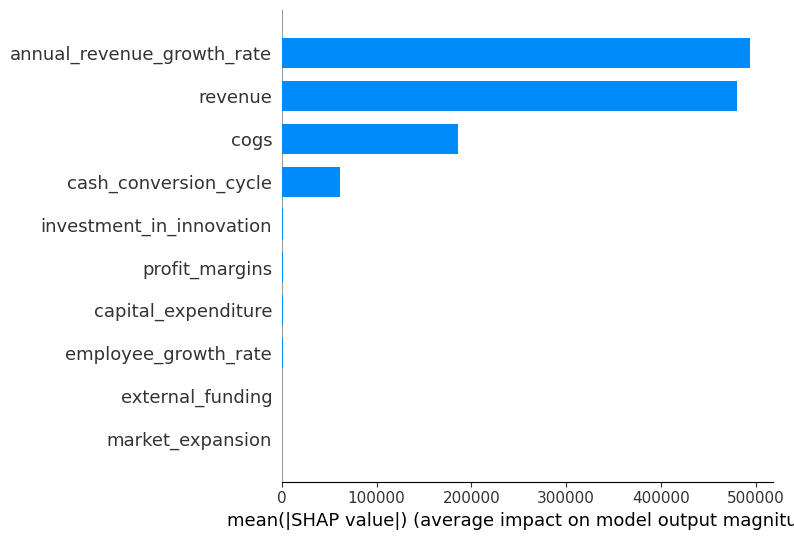

<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

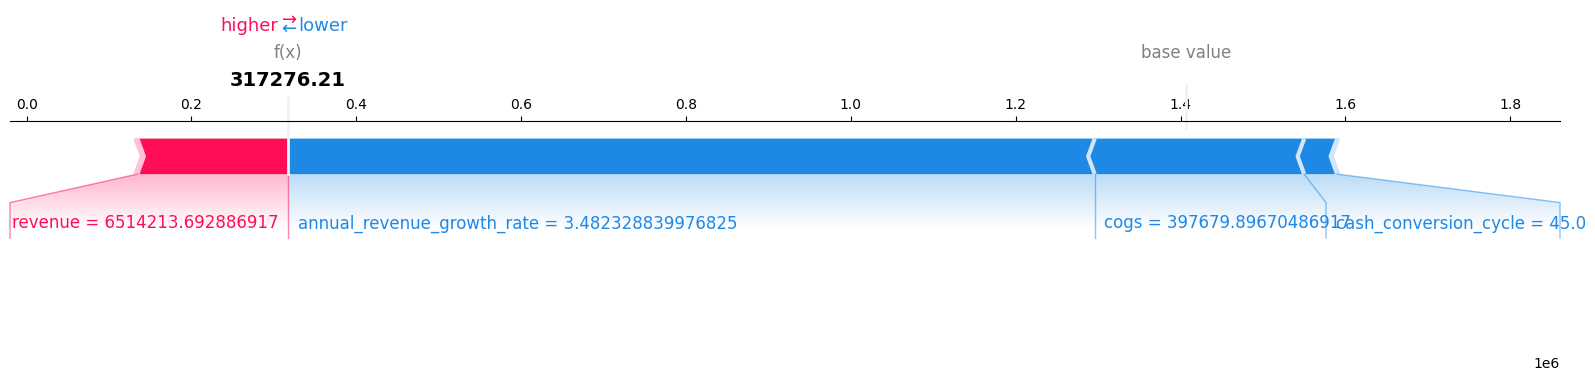

<Figure size 640x480 with 0 Axes>

Predicted Inventory Threshold: 1497264.78


<Figure size 1200x400 with 0 Axes>

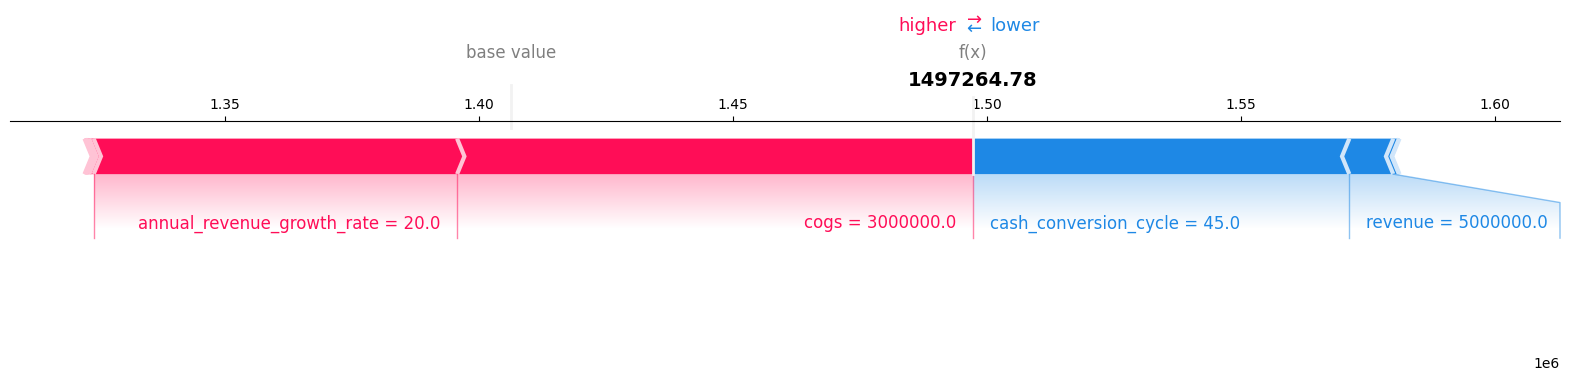

<Figure size 640x480 with 0 Axes>

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features for the model
features = ['revenue', 'cogs', 'annual_revenue_growth_rate', 'market_expansion', 'investment_in_innovation', 'capital_expenditure', 'employee_growth_rate', 'profit_margins', 'external_funding', 'cash_conversion_cycle']
X = data[features]
y = data['inventory_threshold']

# Convert boolean columns to integers
X['market_expansion'] = X['market_expansion'].astype(int)
X['external_funding'] = X['external_funding'].astype(int)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simulate federated learning by splitting data into "clients"
num_clients = 3
client_data = np.array_split(X_train_scaled, num_clients)
client_labels = np.array_split(y_train, num_clients)
from sklearn.ensemble import RandomForestRegressor

def federated_learning(client_data, client_labels, num_rounds=5):
    global_model = RandomForestRegressor(n_estimators=100, random_state=42)

    for round in range(num_rounds):
        print(f"Round {round + 1}")
        client_predictions = []

        for i in range(len(client_data)):
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(client_data[i], client_labels[i])
            client_predictions.append(model.predict(np.concatenate(client_data)))

        # Aggregate predictions (simple averaging)
        aggregated_predictions = np.mean(client_predictions, axis=0)

        # Update global model
        global_model.fit(np.concatenate(client_data), aggregated_predictions)

    return global_model

# Train the federated model
federated_model = federated_learning(client_data, client_labels)
from sklearn.metrics import mean_squared_error

# Evaluate the model
y_pred = federated_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f"Model MSE: {mse:.2f}")
import shap

explainer = shap.TreeExplainer(federated_model)

# Generate SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)

# Create a summary plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type="bar")
plt.tight_layout()
plt.show()

# Create a SHAP force plot for a single prediction
plt.figure(figsize=(12, 4))
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], feature_names=features, matplotlib=True)
plt.tight_layout()
plt.show()
new_data = pd.DataFrame({
    'revenue': [5000000],
    'cogs': [3000000],
    'annual_revenue_growth_rate': [20],
    'market_expansion': [1],  # True
    'investment_in_innovation': [15],
    'capital_expenditure': [12],
    'employee_growth_rate': [25],
    'profit_margins': [8],
    'external_funding': [1],
    'cash_conversion_cycle': [45]
})

# Scale the new data using the same scaler used for training data
new_data_scaled = scaler.transform(new_data)

# Predict the inventory threshold
predicted_threshold = federated_model.predict(new_data_scaled)
print(f"Predicted Inventory Threshold: {predicted_threshold[0]:.2f}")

# Generate SHAP values for the new data point
new_shap_values = explainer.shap_values(new_data_scaled)

# Create a force plot for the new prediction
plt.figure(figsize=(12, 4))
shap.force_plot(explainer.expected_value, new_shap_values[0], new_data.iloc[0], feature_names=features, matplotlib=True)
plt.tight_layout()
plt.show()

In [23]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c4639bfd08c6b312eeada9ae99116815a7af4efc7fc0f3897f2a10a401dc03ff
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


<ipython-input-26-9af45de24cf7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['market_expansion'] = X['market_expansion'].astype(int)
<ipython-input-26-9af45de24cf7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['external_funding'] = X['external_funding'].astype(int)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Round 1
Round 2
Round 3
Round 4
Round 5
Model MSE: 12798927191.36


<Figure size 1000x600 with 0 Axes>

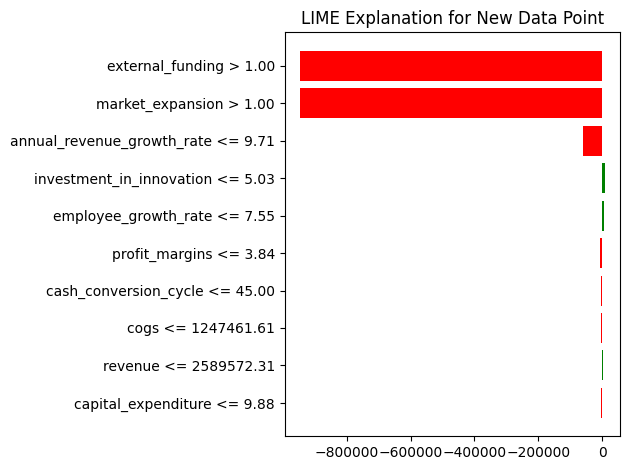

LIME Feature Importance for New Data Point:
external_funding > 1.00: -946887.8218470385
market_expansion > 1.00: -946887.8218470378
annual_revenue_growth_rate <= 9.71: -58600.73494367441
investment_in_innovation <= 5.03: 8251.453741742947
employee_growth_rate <= 7.55: 7407.567587103001
profit_margins <= 3.84: -5361.007605615589
cash_conversion_cycle <= 45.00: -3737.857804503897
cogs <= 1247461.61: -2617.0099342892154
revenue <= 2589572.31: 2367.2973391666987
capital_expenditure <= 9.88: -1964.5035229117777


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features for the model
features = ['revenue', 'cogs', 'annual_revenue_growth_rate', 'market_expansion', 'investment_in_innovation', 'capital_expenditure', 'employee_growth_rate', 'profit_margins', 'external_funding', 'cash_conversion_cycle']
X = data[features]
y = data['inventory_threshold']

# Convert boolean columns to integers
X['market_expansion'] = X['market_expansion'].astype(int)
X['external_funding'] = X['external_funding'].astype(int)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simulate federated learning by splitting data into "clients"
num_clients = 3
client_data = np.array_split(X_train_scaled, num_clients)
client_labels = np.array_split(y_train, num_clients)
from sklearn.ensemble import RandomForestRegressor

def federated_learning(client_data, client_labels, num_rounds=5):
    global_model = RandomForestRegressor(n_estimators=100, random_state=42)

    for round in range(num_rounds):
        print(f"Round {round + 1}")
        client_predictions = []

        for i in range(len(client_data)):
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(client_data[i], client_labels[i])
            client_predictions.append(model.predict(np.concatenate(client_data)))

        # Aggregate predictions (simple averaging)
        aggregated_predictions = np.mean(client_predictions, axis=0)

        # Update global model
        global_model.fit(np.concatenate(client_data), aggregated_predictions)

    return global_model

# Train the federated model
federated_model = federated_learning(client_data, client_labels)
from sklearn.metrics import mean_squared_error

# Evaluate the model
y_pred = federated_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f"Model MSE: {mse:.2f}")

new_data = pd.DataFrame({
    'revenue': [5000000],
    'cogs': [3000000],
    'annual_revenue_growth_rate': [20],
    'market_expansion': [1],  # True
    'investment_in_innovation': [15],
    'capital_expenditure': [12],
    'employee_growth_rate': [25],
    'profit_margins': [8],
    'external_funding': [1],
    'cash_conversion_cycle': [45]
})
import lime
from lime import lime_tabular

# Create the LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X.columns,
    mode='regression'
)
# Scale the new data using the same scaler used for training data
new_data_scaled = scaler.transform(new_data)

new_exp = lime_explainer.explain_instance(
    new_data_scaled[0],
    federated_model.predict,
    num_features=len(features)
)

# Visualize the LIME explanation for the new data point
plt.figure(figsize=(10, 6))
new_exp.as_pyplot_figure()
plt.title("LIME Explanation for New Data Point")
plt.tight_layout()
plt.show()

# Print feature importance as text
print("LIME Feature Importance for New Data Point:")
for feature, importance in new_exp.as_list():
    print(f"{feature}: {importance}")
